# DL Lab 2.1 - Homework - Building ConvNets for Image Classification

In this homework, you will build a Convolutional Neural Network ('ConvNet' or 'CNN') for classifying 10 plant species by images of their flowers. In detail, you will perform the following steps:
1. Explore and Preprocess the data
2. Build a ConvNet from scratch
3. Evaluate training and validation accuracy
4. Add regularization techniques

**After completing this homework you will be able to**

- **design ConvNet models** using **TensorFlow Keras**
- use **data generators** for loading and feeding images to your model
- **train** models from scratch
- **evaluate** the training process.
- augment your training data using **image augmentation** techniques
- use **Dropout** and **Batch normalization**.

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines marked by "<font color='green'>`# TODO`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" in the "<font color='green'>`# TODO`</font>" comments to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.
- If you get stuck, check your Lecture and Lab notes and use the [discussion forum](https://moodle2.tu-ilmenau.de/mod/forum/view.php?id=102963) in Moodle.


Let's get started!

**Note**: Training a ConvNet is a computationally expensive process. Most of the computations can be parallelized very efficently, making them a perfect fit for GPU-acceleration. In order to enable a GPU for your Colab session, do the following steps:
- Click '*Runtime*' -> '*Change runtime type*'
- In the pop-up window for '*Hardware accelerator*', select '*GPU*' 
- Click '*Save*'

# 0 - Test for GPU

Execute the code below for printing the TF version and testing for GPU availability.

In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.3.0
Found GPU at: /device:GPU:0

Wed Nov 11 16:25:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |    359MiB / 16280MiB |      6%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                 

# 1 - Explore and Preprocess the Data

## 1.1 - Download and Plot the Data

We'll start by downloading our dataset, composed of 1000 JPG images contained in a zip archive. Execute the code below for downloading and extracting the data to `/tmp/flowers10.zip`.

In [2]:
#@title Dataset Downloader
import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
def unzip(file):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

download_file_from_google_drive('1N4hmUQDJuimnB-98l8NGrNMo7eghNN1Y', '/tmp/flowers10.zip')
unzip('/tmp/flowers10.zip')

The base directory `/tmp/flowers10` contains the `train` and `val` subdirectories for the training and validation splits. Let's define each of these directories:

In [3]:
base_dir = '/tmp/flowers10/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Let's find out the number of images and classes:

In [4]:
#@title Print Dataset Statistics

import glob
import numpy as np

train_images = glob.glob(os.path.join(train_dir,'*', '*.jpg'))
validation_images = glob.glob(os.path.join(validation_dir,'*', '*.jpg'))

train_classes = [os.path.basename(os.path.dirname(x)) for x in train_images]
validation_classes = [os.path.basename(os.path.dirname(x)) for x in validation_images]

assert len(set(train_classes))==len(set(validation_classes)), 'Class mismatch between train and val'
classes = set(train_classes)
num_classes = len(classes)

for class_ in classes:
  print('Class {}: training images: {}, validation images: {}'.format(class_, train_classes.count(class_), validation_classes.count(class_)))
print('\nTotal training images:', len(train_images))
print('Total validation images:', len(validation_images))
print('Number of classes:', num_classes)

Class 85: training images: 80, validation images: 20
Class 60: training images: 80, validation images: 20
Class 117: training images: 80, validation images: 20
Class 129: training images: 80, validation images: 20
Class 156: training images: 80, validation images: 20
Class 141: training images: 80, validation images: 20
Class 38: training images: 80, validation images: 20
Class 259: training images: 80, validation images: 20
Class 7: training images: 80, validation images: 20
Class 21: training images: 80, validation images: 20

Total training images: 800
Total validation images: 200
Number of classes: 10


We inspect few images to get a better sense of what these flowers look like:

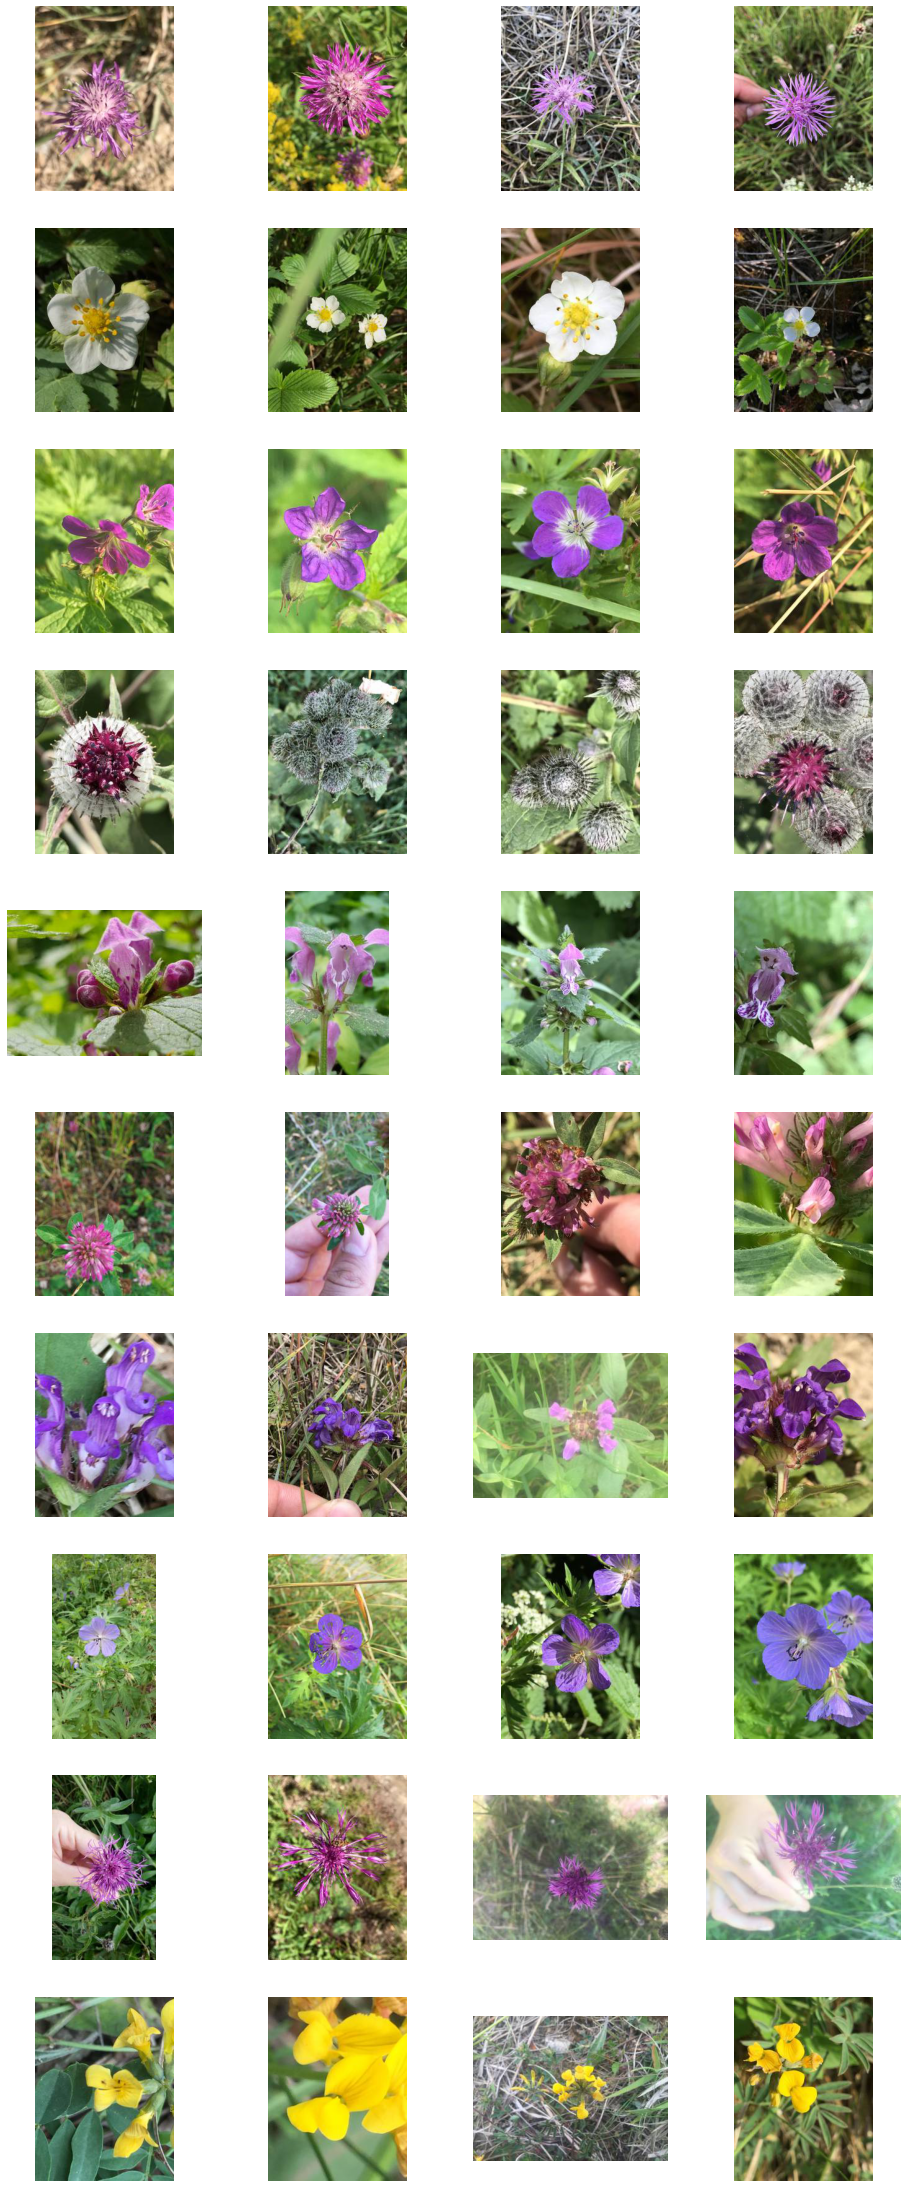

In [5]:
#@title Plot images
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = num_classes
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for row, class_ in enumerate(classes):
  class_images = [img for img,label in zip(validation_images, validation_classes) if label==class_]
  for col in range(ncols):
    sp = plt.subplot(nrows, ncols, row*ncols+col+1)
    sp.axis('Off')
    img = mpimg.imread(class_images[col])
    plt.imshow(img)
    
plt.show()

## 1.2 - Setting up Data Generators

In contrast to the last labs, the dataset is composed of the **original image files** instead of one `np.ndarray` held in the memory. In addition, the **image sizes won't fit** the input specifications of the ConvNet you will design below.

In order to actually load the images to (GPU) memory, you will set up **data generators** that will 
1. read images from the source directories,
2. convert them to `float32` tensors,
3. and feed them (along with their labels) to your ConvNet.

There is an up-and-ready [**ImageDataGenerator** class](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) in tf.keras which does the job for you.

You will have **one generator per split**, i.e., one generator for training images and another for validation images. 

In addition, you will **normalize** the pixel values to `[0,1]` range using the `rescale` argument of the `ImageDataGenerator`.

**Task**: Complete the code below according to the input specifications defined in the text. Familiarize yourself with the [ImageDataGenerator class in tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize each one `ImageDataGenerator` for the training and validation data
# Use the `rescale` argument to rescale the images `1./255`

### START YOUR CODE HERE ### (2 LOC)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
### END YOUR CODE HERE ###

The images are organized in a structured hierarchy of directories:


In [7]:
!find $base_dir -type d | sed -e "s/[^-][^\/]*\//  |/g" -e "s/|\([^ ]\)/|-\1/"

  |  |
  |  |-val
  |  |  |-156
  |  |  |-117
  |  |  |-60
  |  |  |-85
  |  |  |-38
  |  |  |-141
  |  |  |-21
  |  |  |-129
  |  |  |-7
  |  |  |-259
  |  |-train
  |  |  |-156
  |  |  |-117
  |  |  |-60
  |  |  |-85
  |  |  |-38
  |  |  |-141
  |  |  |-21
  |  |  |-129
  |  |  |-7
  |  |  |-259


The top level directory will define the data split: either `val` for the validation data or `train` for the training data. Each top level  directory contains the subdirectories for the respective classes, i.e., `129`, `85`, and so on, in which the image files are found.

The [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method of Keras' `ImageDataGenerator` scans the validation or training data directories for these class-specific subdirectories and the images contained in them. Ultimately, the `flow_from_directory` is used for generating batches of your data. 
You can control the batch size using the argument `batch_size`.
If the `class_mode` argument is set to `'categorical'`, the class labels will be returned as one-hot encoded labels.
In addition, you can use the `target_size` argument for specifying the dimensions your images will be rescaled to.

**Task**: Use the `flow_from_directory` method to generate **batches of 32 images** with `target_size=(150, 150)` and one-hot encoded labels.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use the `flow_from_directory` method for scanning the training directory for 
# images in the class' subdirectories and generating batches
# Note: the `target_size` only refers to (width, height) of an image

### START YOUR CODE HERE ### (3 LOC)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=(150, 150),
    batch_size=batch_size)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,target_size=(150, 150),
    batch_size=batch_size)

### END YOUR CODE HERE ###

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


Let's have a look on one batch, which itself is a `tuple([x], [y])` of input data `x` and corresponding labels `y`:

In [9]:
batch = validation_generator.next()

for label_el, batch_el in zip(('x','y'), batch):
  print('{} shape: {}'.format(label_el, batch_el.shape))
  print('{} example: {}'.format(label_el, batch_el[0]))
  print()
  
validation_generator.reset()

x shape: (32, 150, 150, 3)
x example: [[[0.7176471  0.6431373  0.61960787]
  [0.7294118  0.654902   0.6313726 ]
  [0.77647066 0.70980394 0.68235296]
  ...
  [0.4784314  0.52156866 0.49803925]
  [0.4784314  0.52156866 0.4901961 ]
  [0.50980395 0.5568628  0.5176471 ]]

 [[0.7058824  0.6392157  0.6117647 ]
  [0.7254902  0.65882355 0.6313726 ]
  [0.7294118  0.67058825 0.6431373 ]
  ...
  [0.44705886 0.49803925 0.46274513]
  [0.45098042 0.5019608  0.46274513]
  [0.48627454 0.5372549  0.49803925]]

 [[0.7019608  0.63529414 0.60784316]
  [0.7137255  0.654902   0.627451  ]
  [0.69803923 0.64705884 0.6156863 ]
  ...
  [0.41960788 0.48235297 0.4431373 ]
  [0.43529415 0.49803925 0.454902  ]
  [0.4784314  0.5411765  0.4901961 ]]

 ...

 [[0.4901961  0.4784314  0.45098042]
  [0.49411768 0.49411768 0.46274513]
  [0.46274513 0.4666667  0.43529415]
  ...
  [0.6431373  0.7176471  0.6313726 ]
  [0.6784314  0.7372549  0.654902  ]
  [0.69803923 0.7490196  0.6784314 ]]

 [[0.48235297 0.4901961  0.44705886]

# 2 - Build a ConvNet from Scratch

## 2.1 - Defining the Model Architecture

Next you shall code the architecture defined in the Lab: you will stack **3 blocks**, each constituted of a [Conv2D layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) with ReLU activation and a [MaxPool2D layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). 
All convolutions shall have filters of size **3x3** wheras the maxpooling layers shall have filters of size **2x2**. The first convolution shall have **16 filters**, the following **32 filters**, and the last **64 filters**. The activation function can either be set using a [`ReLU` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU) after each `Conv2D` layer, or by specifying the activation function as `'relu'` using the `activation` argument of the `Conv2D` layers.

The last maxpool operation could be implemented as `MaxPool2D` layer with **34x34** filter size (that's the width and height of your last feature map). However, it is easier to use a [`GlobalMaxPool2D` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D), which pools the feature maxima across the feature maps entire height and width irrespective of their spatial dimensions.

The result should be a tensor of shape `64` which will be feeded into a [`Dense` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with `10` neurons (= number of classes) for classification. Don't forget to specify the correct `activation` function for multi-class classification!

You will use Keras' Functional API to create the model in TensorFlow. The Functional API allows to create flexible models with non-linear topology, shared layers, as well as multiple inputs and/or outputs. The basic idea behind the Functional API is that a deep learning model is usually a directed acyclic graph of layers. Hence, Keras' Functional API is a set of tools for building graphs of layers.

By calling all the different layers on their respective output tensors, you specifiy the architecture, i.e., the flow of tensors during forward and backward propagation.

You can then proceed to group all these layers into a trainable [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model). With the Functional API, you create a model by defining its input and output tensors.

If you want to read more about Keras and the Functional API, visit the [TensorFlow documentation](https://www.tensorflow.org/guide/keras/functional).

**Task**:  Build the architecture using Keras' Functional API, then create the model by defining the input and output tensors.

In [10]:
from tensorflow.keras import layers, Model

def build_model(num_classes, input_shape=(150, 150, 3)):

  # Input layer returning the `input_img` tensor
  input_img = layers.Input(shape=input_shape)

  ### START YOUR CODE HERE ### (~7 LOC)

  # First block: 16 convolution filters (3x3), relu, maxpool
  x = layers.Conv2D(filters=16, kernel_size=3, activation='relu')(input_img)
  x1 = layers.MaxPooling2D(2)(x)
  # Second block: 32 convolution filters (3x3), relu, maxpool
  x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x1)
  x2_1= layers.MaxPooling2D(2)(x2)
  # Third block: 64 filters (3x3), relu
  x3 = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x2_1)
  # GlobalMaxPool
  xglob = layers.GlobalMaxPool2D()(x3)
  # Create the output layer with `num_classes` nodes and softmax activation
  output = layers.Dense(num_classes, activation='softmax')(xglob)

  ### END YOUR CODE HERE ###

  # Build the model by defining the input and output tensors
  model = Model(input_img, output)

  return model

To get an overview on the chain of layers of your model, the respective tensor shapes, and the number of layer parameters, you can print the [`Model.summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary). If you did everything correct, your model contains 24'234 parameters:

In [11]:
model = build_model(num_classes)
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
global_max_pooling2d (Global (None, 32)               

## 2.2 - Compiling the Model

You are now ready to compile your model. Compiling the model requires three parameters:
1. an optimizer,
2. a loss function, and
3. evaluation metrics.

The **optimizer** controls the learning rate. You will be using `Adam`, which adjusts the learning rate troughout the training process and often allows for good results without much effort in tuning the optimization process.

As you have a multi-class problem, you will be using `categorical_crossentropy` as **loss function**. Please note that there's also a loss termed `sparse_categorical_crossentropy`, which is used if the training targets `y` are *integers* in contrast to *one-hot encoded* labels.

At last, define `accuracy` as **metric** for assessing the performance of your ConvNet on the validation set during training.

In [12]:
from tensorflow.keras.optimizers import Adam

learning_rate = 3e-4

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

## 2.3 - Training the Model

You can now use the  [`fit()` method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) of your [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) for training the ConvNet on all training images. At the end of each epoch, the metrics are computed on the validation images.

**Task**: Train the model for 100 epochs.

In [13]:
train_steps = np.ceil(train_generator.samples / train_generator.batch_size)  # 800 images = batch_size * steps
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)  # 200 images = batch_size * steps

### START YOUR CODE HERE ### (1 LOC)
history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    verbose=2)
### END YOUR CODE HERE ###

Epoch 1/100
25/25 - 2s - loss: 2.3049 - accuracy: 0.1462 - val_loss: 2.2907 - val_accuracy: 0.1750
Epoch 2/100
25/25 - 2s - loss: 2.2715 - accuracy: 0.2225 - val_loss: 2.2580 - val_accuracy: 0.2250
Epoch 3/100
25/25 - 2s - loss: 2.2264 - accuracy: 0.2637 - val_loss: 2.1989 - val_accuracy: 0.2400
Epoch 4/100
25/25 - 2s - loss: 2.1429 - accuracy: 0.2962 - val_loss: 2.1023 - val_accuracy: 0.2600
Epoch 5/100
25/25 - 2s - loss: 2.0139 - accuracy: 0.3350 - val_loss: 1.9662 - val_accuracy: 0.3800
Epoch 6/100
25/25 - 2s - loss: 1.8546 - accuracy: 0.4313 - val_loss: 1.8045 - val_accuracy: 0.4100
Epoch 7/100
25/25 - 2s - loss: 1.6874 - accuracy: 0.4688 - val_loss: 1.6538 - val_accuracy: 0.4350
Epoch 8/100
25/25 - 2s - loss: 1.5315 - accuracy: 0.5325 - val_loss: 1.5125 - val_accuracy: 0.5750
Epoch 9/100
25/25 - 2s - loss: 1.4041 - accuracy: 0.5375 - val_loss: 1.4126 - val_accuracy: 0.5850
Epoch 10/100
25/25 - 2s - loss: 1.2984 - accuracy: 0.5925 - val_loss: 1.3318 - val_accuracy: 0.6450
Epoch 11/

## 2.3 - Evaluating Accuracy and Loss for the Model

The `Model.fit()` method returns the history of the training process, containing the loss and metric(s) defined during model compilation.

Let's plot the training/validation accuracy and loss as collected during training.

In [14]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show()

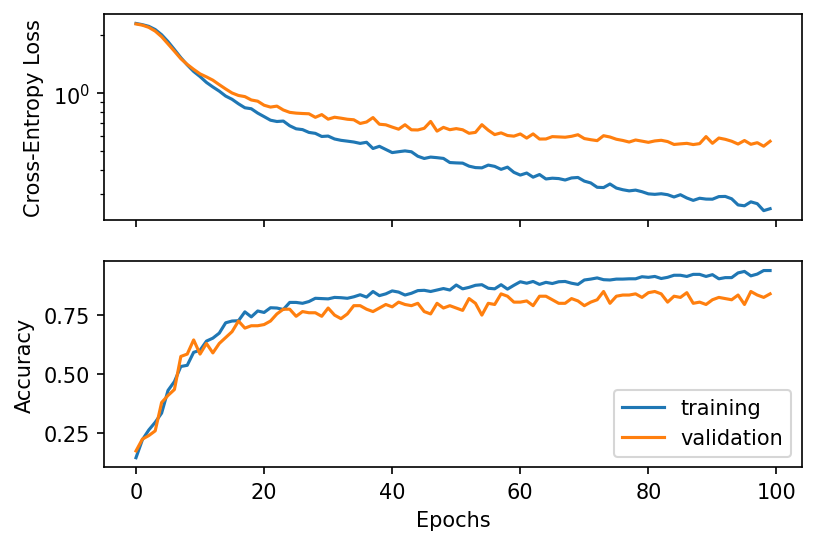

In [15]:
plot_history(history)

The accuracy and loss on the validation data start to diverge from the curves of the training data. This indicates that your model has problems in generalizing from training data to validation data. Ultimately, your model might start memorizing the training data, i.e., learning a perfect mapping between the training samples and their labels. However, this would be entirely useless when making predictions on previously unseen data.

#3 - Improving Generalization

Deep Learning models can be very powerful at fitting data. However, the real challenge in Deep Learning is generalization, not fitting.

Here, you will add three common strategies to your model in order to reduce overfitting and improve generalization:
- Data augmentation and random shuffling
- DropOut
- Batch Normalization.

## 3.1 - Data Augmentation and Random Shuffling
In order to make most of your few training examples, you'll **augment** them by a number of random transformations. During training, our model will **never** see the exact same image again.

In Keras, this can be done by configuring  the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to use apply predefined transformations randomly on the images.

In detail, you will add following transformations:
- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `zoom_range` is for randomly zooming inside pictures.
- `brightness_range` shifts the brightness of images within the range specified as tuple. Values smaller than `1.0` darken the image whereas values larger than `1.0` brighten the image. E.g., `(.5, 1.5)` randomly shifts between 50% and 150% of original image brightness.
- `horizontal_flip` is for randomly flipping the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- `vertical_flip` is for randomly flipping the images vertically. This is relevant when there are no assumptions of vertical assymmetry (e.g. top-view images of flowers).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

**Note**: These are just a few of the options available. Check the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for more.

**Task**: Initialize an ImageDataGenerator with up to 20° random image rotation, 10% vertical and horizontal random image translation, 40% random zoom, 50% to 150% brightness shift, and random horizontal and vertical flipping. Don't forget to also rescale the data.

In [16]:
### START YOUR CODE HERE ### (1 LOC)
train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=20,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=.4,
    brightness_range=(.5, 1.5),
    vertical_flip=True,
    horizontal_flip=True)
### END YOUR CODE HERE ###

In addition to applying augmentation techniques to the training data, you should also **shuffle the training data**. You can enable shuffling by setting `shuffle=True` in the `flow_from_directory` method. The training data is then shuffled after each epoch. This way, the network will never see the same mini-batch composition again, which helps to avoid getting stuck in local minima!

In [17]:
# Flow training images in random batches of `batch_size` using train_datagen generator
### START YOUR CODE HERE ### (1 LOC)
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150,150),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True,
                    seed=42)
### END YOUR CODE HERE ###

Found 800 images belonging to 10 classes.


Let's take a look at your augmented images:

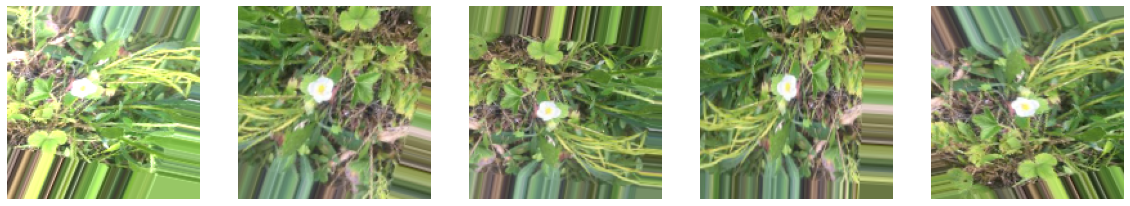

In [18]:
#@title Plot Augmented Images

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = train_images[int(np.random.random() * len(train_images))]
img = load_img(img_path, target_size=(150,150)) # PIL image
x = img_to_array(img) # Numpy array with shape (150,150,3)
x = x.reshape((1,) + x.shape) # Pseudo-batch, i.e., Numpy array with array (1,150,150,3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to break the loop...

n_runs = 5
fig = plt.gcf()
fig.set_size_inches(n_runs*4,4)

i=0
for batch in train_datagen.flow(x, batch_size=1):
  sp = plt.subplot(1, n_runs, i+1)
  sp.axis('Off')
  plt.imshow(array_to_img(batch[0]))
  i+=1
  if i % n_runs == 0:
    break
    
plt.show()

If you train a network using this data augmentation configuration, the network will never see the exact same input twice.

**Task**: Build and compile another model and train it for 100 epochs on the augmented and shuffled training data.

Epoch 1/100
25/25 - 6s - loss: 2.3100 - accuracy: 0.1000 - val_loss: 2.2913 - val_accuracy: 0.1250
Epoch 2/100
25/25 - 6s - loss: 2.2745 - accuracy: 0.1675 - val_loss: 2.2479 - val_accuracy: 0.2350
Epoch 3/100
25/25 - 6s - loss: 2.2196 - accuracy: 0.3113 - val_loss: 2.1613 - val_accuracy: 0.3700
Epoch 4/100
25/25 - 6s - loss: 2.1128 - accuracy: 0.3388 - val_loss: 2.0167 - val_accuracy: 0.3350
Epoch 5/100
25/25 - 6s - loss: 1.9562 - accuracy: 0.3812 - val_loss: 1.8258 - val_accuracy: 0.4200
Epoch 6/100
25/25 - 6s - loss: 1.7663 - accuracy: 0.4100 - val_loss: 1.6559 - val_accuracy: 0.4550
Epoch 7/100
25/25 - 6s - loss: 1.6024 - accuracy: 0.5025 - val_loss: 1.5235 - val_accuracy: 0.4550
Epoch 8/100
25/25 - 6s - loss: 1.4422 - accuracy: 0.5800 - val_loss: 1.3982 - val_accuracy: 0.5700
Epoch 9/100
25/25 - 6s - loss: 1.3444 - accuracy: 0.6275 - val_loss: 1.3096 - val_accuracy: 0.6050
Epoch 10/100
25/25 - 6s - loss: 1.2486 - accuracy: 0.6313 - val_loss: 1.2106 - val_accuracy: 0.6200
Epoch 11/

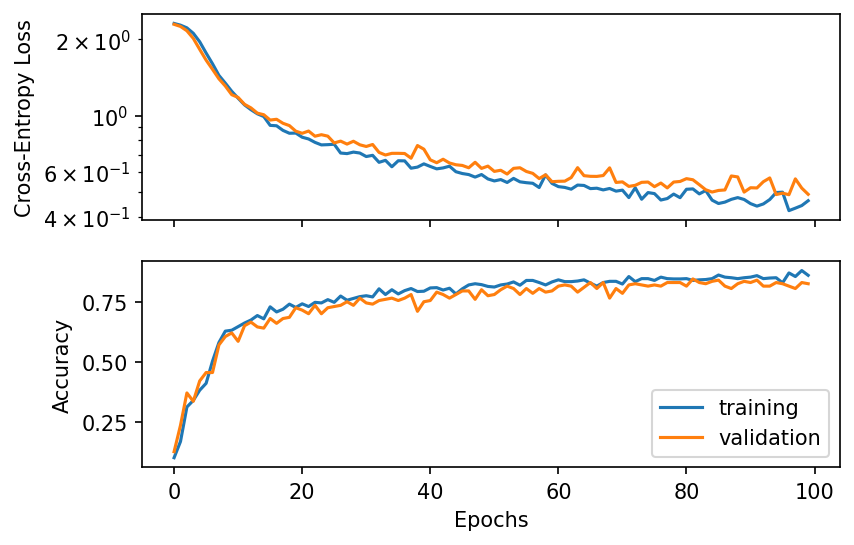

In [19]:
model = build_model(num_classes)

### START YOUR CODE HERE ### (2 LOC)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    verbose=2)

### END YOUR CODE HERE ###

plot_history(history)

## 3.2 - Adding Dropout

Dropout is one of the most commonly used regularization techniques for neural networks. The intuition behind Dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g., `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In tf.keras you can introduce dropout in a network via the [`Dropout` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), which gets applied to the output of the preceeding layer.

**Task**: Build a new model with same architecture as before but added a Dropout layer with `.2` dropout rate before the output layer.

In [20]:
def build_model_with_dropout(num_classes, input_shape=(150,150,3), learning_rate=1e-3, summary=True):
  
  # Input layer returning the `input_img` tensor
  input_img = layers.Input(shape=input_shape)

  ### START YOUR CODE HERE ### (~8 LOC)

  # First block: 16 convolution filters (3x3), relu, maxpool
  x = layers.Conv2D(filters=16, kernel_size=3, activation='relu')(input_img)
  x1 = layers.MaxPooling2D(2)(x)
  # Second block: 32 convolution filters (3x3), relu, maxpool
  x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x1)
  x2_1 = layers.MaxPooling2D(2)(x2)
  # Third block: 64 filters (3x3), relu
  x3 = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x2_1)
  # GlobalMaxPool
  xglob = layers.GlobalMaxPool2D()(x3)
  # Dropout layer with .2 dropout rate
  xdrop = layers.Dropout(rate=.2)(xglob)
  # Create the output layer with `num_classes` nodes and softmax activation
  output = layers.Dense(num_classes, activation='softmax')(xdrop)

  ### END YOUR CODE HERE ###

  # Finally, create the model by defining input and output layers
  model = Model(input_img, output)
  
  # Compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=learning_rate),
                metrics=['accuracy'])
  
  if summary:
    print(model.summary())
  
  return model

Train and evaluate the model with dropout for 100 epochs:

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 32)               

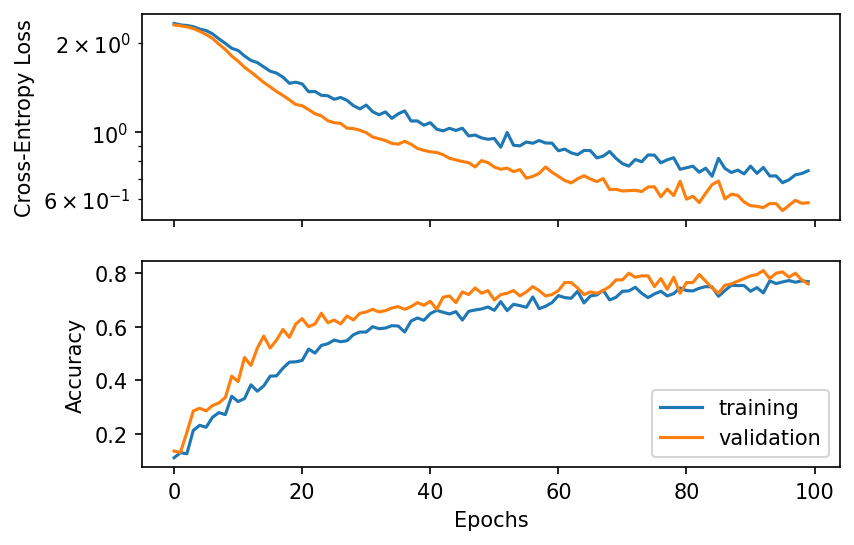

In [21]:
dropout_model = build_model_with_dropout(num_classes, learning_rate=learning_rate)

### START YOUR CODE HERE ### (1 LOC)

history = dropout_model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    verbose=2)

### END YOUR CODE HERE ###

plot_history(history)

## 3.3 - Adding Batch Normalization (BN)

Although BN is originally intended to speed-up the training process by normalizing layer outputs, it also has a slight regularization effect as mean and variance change with every minibatch. Scaled with the BN parameters, this induces some small noise that ultimately has the regularization effect.

**Note**: Using BN makes the bias values unneccessary. You may remove the bias values from the convolution layers by setting the `use_bias` to `False`.

**Task**: Reconfigure your ConvNet architecture and add BatchNorm layers, right after each convolutional layer.

In [22]:
def build_model_with_batchnorm(num_classes, input_shape=(150,150,3), learning_rate=1e-3, summary=True):
  
  # Input layer returning the `input_img` tensor
  input_img = layers.Input(shape=input_shape)

  ### START YOUR CODE HERE ### (~10 LOC)

  # First block: 16 convolution filters (3x3), relu, BN, maxpool
  x = layers.Conv2D(filters=16, kernel_size=3, activation='relu', use_bias=False)(input_img)
  x1 = layers.BatchNormalization()(x)
  x1_1 = layers.MaxPooling2D(2)(x1)
  # Second block: 32 convolution filters (3x3), relu, BN, maxpool
  x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', use_bias=False)(x1_1)
  x2_1 = layers.BatchNormalization()(x2)
  x2_2 = layers.MaxPooling2D(2)(x2_1)
  # Third block: 64 filters (3x3), relu, BN
  x3 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', use_bias=False)(x2_2)
  x3_1 = layers.BatchNormalization()(x3)
  # GlobalMaxPool
  xglob = layers.GlobalMaxPool2D()(x3_1)
  # Create the output layer with `num_classes` nodes and softmax activation
  output = layers.Dense(num_classes, activation='softmax')(xglob)

  ### END YOUR CODE HERE ###

  # Finally, create the model by defining input and output layers
  model = Model(input_img, output)
  
  # Compile the model
  model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])
  
  if summary:
    print(model.summary())
  
  return model

Train and evaluate your model with Batch normalization:

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 148, 148, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)       

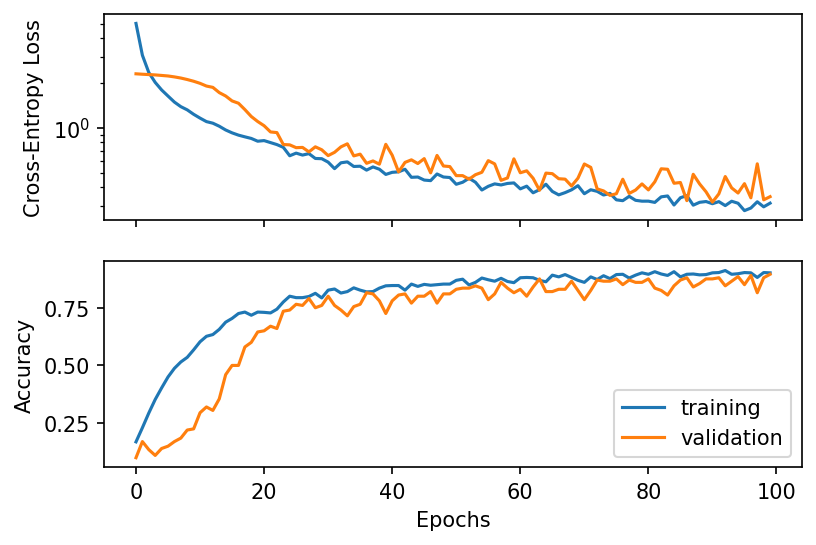

In [23]:
batchnorm_model = build_model_with_batchnorm(num_classes, learning_rate=learning_rate)

### START YOUR CODE HERE ### (1 LOC)

history = batchnorm_model.fit(train_generator,
                              steps_per_epoch=train_steps,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=val_steps,
                              verbose=2)

### END YOUR CODE HERE ###

plot_history(history)

***

# Congratulations!
You built and trained your first ConvNet and should achieve ~90% accuracy! Taking a look on the learning curves, you should have made an important observation:
The accuracy and loss on the validation data started to diverge from the curves of the training data. This indicates that your model has problems in generalizing from training data to validation data, ultimately causing your model to **overfit**.

Using **data augmentation** and **random shuffling** of training data in combination with **DropOut** or **Batch Normalization** helps your models to better generalize. In the experiments conducted here, you should see no overfitting for 100 epochs. In addition, the validation accuracy should have increased. Judging by the training profile, you might continue training with a proper learning rate schedule and further increase the accuracy.

In the next lab, we will discuss and perform transfer-learning and fine-tuning using bigger models.

***

# Submission Instructions

You may now submit your notebook to moodle:
- Enter your email adress in the cell below.
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.

In [24]:
#@title Enter your email address, then run this cell:

email_address = 'islamiia.gilmanova@tu-ilmenau.de' #@param {type:"string"}